# Blackbox internals #2


## Class wrappers

Some very complex interfaces demand some simplification. For example, an IP core equipped with several channels of a set of input/output signals. We introduce an internal `BulkSignal` class as auxiliary for a somewhat
object oriented generation of an interface.
The BulkSignal class is used as a container for interface signals with one fixed direction (in/out).

In [1]:
import config

We have a `ChannelIn` class and a `ChannelOut` class for *in* and *out* signals, respectively.
Note these BulkSignal classes use `__slots__` instead of a dictionary. Since a channel specification
may consist of *in* and *out* bulk signals but share the same prefix, they are initialized
with an explicit name.

In [2]:

from synthesis.yosys.autowrap import autowrap_unroll, unroll_bulk, BulkSignal

class ChannelIn(BulkSignal):
    __slots__ = [ 'TXCLK', 'RXCLK', 'RXVALID', 'RXD' ]

    def __init__(self, name):
        self.RXD = Signal(intbv()[4:])
        for n in self.__slots__[:-1]:
            setattr(self, n, Signal(bool()))
        super().__init__(name, False) # Init as input

class ChannelOut(BulkSignal):
    __slots__ = [ 
        'OUTP', 'OUTN',
        'TXEN',
        'S_UNDERRUN', 'S_OVERRUN',
    ]

    __slots__ += [ 'TXD' ]


    def __init__(self, name):
        self.TXD = Signal(intbv()[4:])
        for n in self.__slots__[:-1]:
            setattr(self, n, Signal(bool()))
        super().__init__(name, True)  # Init as output


Then we define the unroller methods and create a dummy `UNIT` blackbox:

In [3]:
from myhdl import *
from myhdl._Signal import _Signal


@autowrap_unroll(unroll_bulk)
def UNIT(clk, reset, CH0_i, CH1_i, CH0_o, CH1_o, USE_GLOBAL_RESET = False, USE_REFCLK = False):

    @always_seq(clk.posedge, reset)
    def assign():
        CH0_o.S_UNDERRUN.next = False
        CH1_o.S_UNDERRUN.next = False

        
    @instance
    def dummy():
        yield delay(1)
        # Consume reset
        yield (reset.negedge)

    return dummy


from myhdl.conversion import yshelper

@block
def uut(clk, reset, status, out0, out1):

    ch0_i, ch1_i = [ ChannelIn("CH%d" % i) for i in range(2) ]
    ch0_o, ch1_o = [ ChannelOut("CH%d" % i) for i in range(2) ]

    @always_comb
    def assign():
        status.next = concat(intbv(0)[6:], ch0_o.S_UNDERRUN, ch0_o.S_OVERRUN)
        ch0_i.TXCLK.next = clk
        ch0_i.RXCLK.next = clk
        out0.next = concat(ch0_o.OUTP, ch0_o.OUTN)
        out1.next = concat(ch1_o.OUTP, ch1_o.OUTN)

    u = UNIT(clk, reset, ch0_i, ch1_i, ch0_o, ch1_o)
    return instances()

def convert():
    design = yshelper.Design("classwrapper")

    clk = Signal(bool())
    status = Signal(intbv()[8:])

    reset = ResetSignal(0, 1, False)

    out0, out1 = [Signal(intbv()[2:]) for i in range(2)]


    t = uut(clk, reset, status, out0, out1)
    t.convert("yosys_module", design)
    return design

design = convert()

	Infer blackbox: 'UNIT_0_0'
Adding module with name: UNIT_1_1
Non-Signal member CH0_i__id
Non-Signal member CH1_i__id
Non-Signal member CH0_o__id
Non-Signal member CH1_o__id
Custom mapping black box UNIT_0
Notice: clk has no source
Notice: reset has no source
Adding module with name: UNIT
Adding module with name: uut_1_1_8_2_2
CONVERT_RTL tree >>>>>> 'UUT_ASSIGN' 
++++++++ UNIT_0_0: UNIT_1_1 (Module) ++++++++
Unused port: CH0_RXVALID
Unused port: CH0_RXD
Unused port: CH1_TXCLK
Unused port: CH1_RXCLK
Unused port: CH1_RXVALID
Unused port: CH1_RXD
Unused port: CH0_TXEN
Unused port: CH0_TXD
Unused port: CH1_TXEN
Unused port: CH1_S_UNDERRUN
Unused port: CH1_S_OVERRUN
Unused port: CH1_TXD


/home/pyosys/src/myhdl/myhdl-local/myhdl/_bulksignal.py:70: BulkSignalWarning: Member CH0_TXCLK already instanced
  category=BulkSignalWarning)
/home/pyosys/src/myhdl/myhdl-local/myhdl/_bulksignal.py:70: BulkSignalWarning: Member CH0_RXCLK already instanced
  category=BulkSignalWarning)
/home/pyosys/src/myhdl/myhdl-local/myhdl/_bulksignal.py:70: BulkSignalWarning: Member CH0_OUTP already instanced
  category=BulkSignalWarning)
/home/pyosys/src/myhdl/myhdl-local/myhdl/_bulksignal.py:70: BulkSignalWarning: Member CH0_OUTN already instanced
  category=BulkSignalWarning)
/home/pyosys/src/myhdl/myhdl-local/myhdl/_bulksignal.py:70: BulkSignalWarning: Member CH0_S_UNDERRUN already instanced
  category=BulkSignalWarning)
/home/pyosys/src/myhdl/myhdl-local/myhdl/_bulksignal.py:70: BulkSignalWarning: Member CH0_S_OVERRUN already instanced
  category=BulkSignalWarning)
/home/pyosys/src/myhdl/myhdl-local/myhdl/_bulksignal.py:70: BulkSignalWarning: Member CH1_OUTP already instanced
  category=BulkS

### Module layer

This shows the wrapped instance of the `UNIT` entity.
Only used signals are wired.

Generating RTL image...
Display...


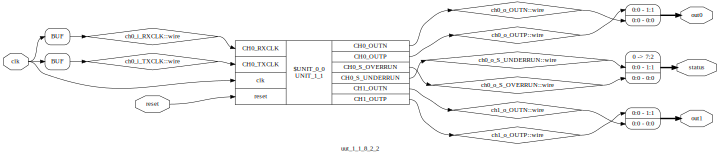

In [4]:
from ys_aux import to_svg
display(to_svg(design, "uut_1_1_8_2_2", 100))

Generating RTL image...
Display...


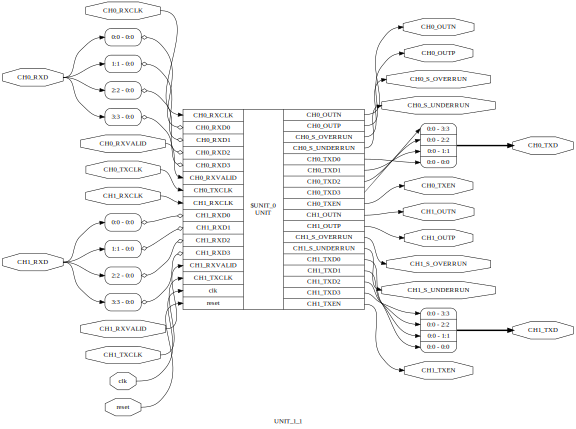

In [5]:
from ys_aux import to_svg
display(to_svg(design, "UNIT_1_1", 80))

In [6]:
design.write_ilang("unroll")
# design.run("hierarchy -check; check")

In [7]:
! cat unroll_mapped.il

# Generated by Yosys 0.9+2406 (git sha1 b822beb1, gcc 8.3.0-6 -Og -fPIC)
autoidx 6
attribute \blackbox 1
module \UNIT
  parameter \USE_GLOBAL_RESET
  parameter \USE_REFCLK
  wire output 10 \CH0_OUTN
  wire output 9 \CH0_OUTP
  wire input 4 \CH0_RXCLK
  wire input 19 \CH0_RXD0
  wire input 20 \CH0_RXD1
  wire input 21 \CH0_RXD2
  wire input 22 \CH0_RXD3
  wire input 5 \CH0_RXVALID
  wire output 13 \CH0_S_OVERRUN
  wire output 12 \CH0_S_UNDERRUN
  wire input 3 \CH0_TXCLK
  wire output 27 \CH0_TXD0
  wire output 28 \CH0_TXD1
  wire output 29 \CH0_TXD2
  wire output 30 \CH0_TXD3
  wire output 11 \CH0_TXEN
  wire output 15 \CH1_OUTN
  wire output 14 \CH1_OUTP
  wire input 7 \CH1_RXCLK
  wire input 23 \CH1_RXD0
  wire input 24 \CH1_RXD1
  wire input 25 \CH1_RXD2
  wire input 26 \CH1_RXD3
  wire input 8 \CH1_RXVALID
  wire output 18 \CH1_S_OVERRUN
  wire output 17 \CH1_S_UNDERRUN
  wire input 6 \CH1_TXCLK
  wire output 31 \CH1_TXD0
  wire output 32 \CH1_TXD1
  wire output 33 \CH1_TXD2
  wire 

In [8]:
design.run("hierarchy -check; check")

In [9]:
! echo Done

Done
